# Methods for Dealing with Imbalanced Data
Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class.  Class imbalance can be found in many different areas including medical diagnosis, spam filtering, and fraud detection.

In this guide, we'll look at five possible ways to handle an imbalanced class problem using credit card data.  Our objective will be to correctly classify the minority class of fraudulent transactions.

Important Note:
This guide will focus solely on addressing imbalanced classes and will not address other important machine learning steps including, but not limited to, feature selection or hyperparameter tuning.

Summary:
There are three methods used: dataset re-assembly, classification changing, upsampling and downsampling with an additional method synthetic sample generation. 

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

In [2]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [3]:
# read in data
df = pd.read_csv('./cache/bak/creditcard.csv')

print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(df.Class.value_counts())

0    284315
1       492
Name: Class, dtype: int64


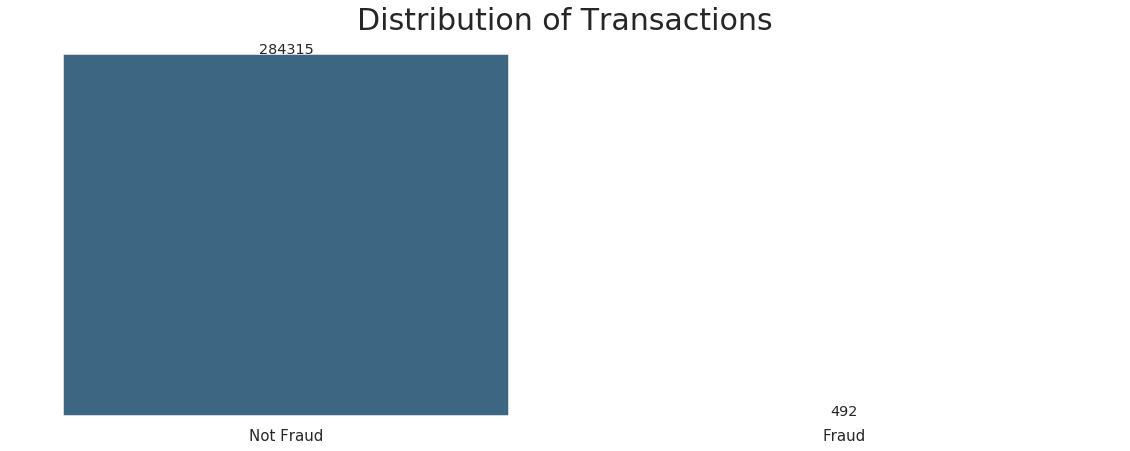

In [5]:
# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(df.Class, palette='viridis')
g.set_xticklabels(['Not Fraud', 'Fraud'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Transactions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [6]:
# print percentage of questions where target == 1
(len(df.loc[df.Class==1])) / (len(df.loc[df.Class == 0])) * 100

0.17304750013189596

From the plot above, we can see we have a very imbalanced class -  just 0.17% of our dataset belong to the target class!

This is a problem because many machine learning models are designed to maximize overall accuracy, which especially with imbalanced classes may not be the best metric to use. Classification accuracy is defined as the number of correct predictions divided by total predictions times 100. For example, if we simply predicted all transactions are not fraud, we would get a classification acuracy score of over 99%!

### Create Train and Test Sets

The training set is used to build and validate the model, while the test set is reserved for testing the model on unseen data.

In [7]:
# Prepare data for modeling
# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

## Baseline Models

In [8]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0]
Test score:  0.9981461194910255


As predicted our accuracy score for classifying all transactions as not fraud is 99.8%!  

As the Dummy Classifier predicts only Class 0, it is clearly not a good option for our objective of correctly classifying fraudulent transactions.

Let's see how logistic regression performs on this dataset.

In [9]:
# Modeling the data as is
# Train model
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

In [10]:
# Checking accuracy
accuracy_score(y_test, lr_pred)

0.9992135052386169

In [11]:
# Checking unique values
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

0    71108
1       94
Name: 0, dtype: int64

Logistic Regression outperformed the Dummy Classifier!  We can see that it predicted 94 instances of class 1, so this is definitely an improvement.  But can we do better?

Let's see if we can apply some techniques for dealing with class imbalance to improve these results.

## 1.  Change the performance metric
Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be misleading.  Metrics that can provide better insight include:
 - **Confusion Matrix:**  a talbe showing correct predictions and types of incorrect predictions.
 - **Precision: **  the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier's exactness. Low precision indicates a high number of false positives.
 - **Recall:**  the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier's completeness. Low recall indicates a high number of false negatives.
 - **F1: Score:**  the weighted average of precision and recall.
 
Since our main objective with the dataset is to prioritize accurately classifying fraud cases the recall score can be considered our main metric to use for evaluating outcomes.


In [12]:
# f1 score
f1_score(y_test, lr_pred)

0.7522123893805309

In [13]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, lr_pred))

,0,1
0,71061,9
1,47,85


In [14]:
recall_score(y_test, lr_pred)

0.6439393939393939

We have a very high accuracy score of 0.999 but a F1 score of only 0.752.  And from the confusion matrix, we can see we are misclassifying several observations leading to a recall score of only 0.64.

## 2. Change the algorithm
While in every machine learning problem, its a good rule of thumb to try a variety of algorithms, it can be especially beneficial with imbalanced datasets.  Decision trees frequently perform well on imbalanced data.  They work by learning a hierachy of if/else questions.  This can force both classes to be addressed.



In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

accuracy_score(y_test, rfc_pred)

0.9995646189713772

In [17]:
# f1 score
f1_score(y_test, rfc_pred)

0.8702928870292888

In [18]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, rfc_pred))

,0,1
0,71067,3
1,28,104


In [19]:
# recall score
recall_score(y_test, rfc_pred)

0.7878787878787878

# Resampling Techniques

## 3. Oversampling Minority Class
Oversampling can be defined as adding more copies of the minority class.  Oversampling can be a good choice when you don't have a ton of data to work with.  A con to consider when undersampling is that it can cause overfitting and poor generalization to your test set.

We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

### **Important Note**
Always split into test and train sets BEFORE trying any resampling techniques!  Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets!  This can allow our model to simply memorize specific data points and cause overfitting.

In [20]:
from sklearn.utils import resample

In [21]:
# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [22]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
264873,161634.0,-0.395578,1.489129,-0.833442,-0.224271,0.369444,-1.453886,0.796593,-0.060403,0.338270,...,0.231624,0.955194,-0.172092,-0.041050,-0.313444,-0.174301,0.064657,-0.036960,2.74,0
163821,116237.0,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,...,0.086306,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,38.44,0
72083,54557.0,1.105167,-0.166253,0.569520,0.681043,-0.259189,0.642792,-0.437034,0.356746,0.441417,...,0.009073,0.293023,-0.028688,-0.242206,0.389813,0.482852,0.010705,-0.008399,1.00,0
196949,131771.0,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,...,-0.137875,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,37.89,0
126213,77959.0,0.835421,-1.191847,0.578455,0.586101,-1.236663,0.194617,-0.532404,0.061561,-0.734344,...,-0.072349,-0.109154,-0.308356,0.011968,0.461350,-0.244810,0.031845,0.060910,237.00,0


In [23]:
# separate minority and majority classes
not_fraud = X[X.Class==0]
fraud = X[X.Class==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.Class.value_counts()

1    213245
0    213245
Name: Class, dtype: int64

In [24]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.Class
X_train = upsampled.drop('Class', axis=1)

upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

upsampled_pred = upsampled.predict(X_test)

In [25]:
# Checking accuracy
accuracy_score(y_test, upsampled_pred)

0.9807589674447347

In [26]:
# f1 score
f1_score(y_test, upsampled_pred)

0.14375000000000002

In [27]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, upsampled_pred))

,0,1
0,69717,1353
1,17,115


In [28]:
recall_score(y_test, upsampled_pred)

0.8712121212121212

Our accuracy score decreased after upsampling, but the model is now predicting both classes more equally, making it an improvement over our plain logistic regression above.

## 4. Undersampling Majority Class
Undersampling can be defined as removing some observations of the majority class.  Undersampling can be a good choice when you have a ton of data -think millions of rows.  But a drawback to undersampling is that we are removing information that may be valuable.

We will again use the resampling module from Scikit-Learn to randomly remove samples from the majority class.

In [29]:
# still using our separated classes fraud and not_fraud from above

# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

1    360
0    360
Name: Class, dtype: int64

In [30]:
# trying logistic regression again with the undersampled dataset

y_train = downsampled.Class
X_train = downsampled.drop('Class', axis=1)

undersampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)

undersampled_pred = undersampled.predict(X_test)

In [31]:
# Checking accuracy
accuracy_score(y_test, undersampled_pred)

0.9758574197354007

In [32]:
# f1 score
f1_score(y_test, undersampled_pred)

0.11710323574730355

In [33]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, undersampled_pred))

,0,1
0,69369,1701
1,18,114


In [34]:
recall_score(y_test, undersampled_pred)

0.8636363636363636

Downsampling produced a higher recall score than upsampling!  My concern here is the small number of total samples we used to train the model.


## 5. Generate Synthetic Samples
SMOTE or Synthetic Minority Oversampling Technique is a popular algorithm to creates sythetic observations of the minority class.
https://imbalanced-learn.readthedocs.io/en/stable/api.html
conda install -c conda-forge imbalanced-learn

In [35]:
from imblearn.over_sampling import SMOTE

# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=27, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [36]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred = smote.predict(X_test)

# Checking accuracy
accuracy_score(y_test, smote_pred)

0.9858571388444145

In [37]:
# f1 score
f1_score(y_test, smote_pred)

0.18461538461538463

In [38]:
# confustion matrix
pd.DataFrame(confusion_matrix(y_test, smote_pred))

,0,1
0,70081,989
1,18,114


In [39]:
recall_score(y_test, smote_pred)

0.8636363636363636

## Conclusion

We covered 5 different methods for dealing with imbalanced datasets:
1.  Change the performance metric
2.  Oversampling minority class
3.  Undersampling majority class
4.  Change the algorithm
5.  Generate synthetic samples

These are just some of the many possible methods to try when dealing with imbalanced datasets, and not an exhaustive list.  Some others methods to consider are collecting more data or choosing different resampling ratios - you don't have to have exactly a 1:1 ratio!  You should always try several approaches and then decide which is best for your problem.